We'd like to analyze the data from the newsgroup dataset. But first, we have to process the files to be easier to load in for graphs, as well as to read. We can do this by turning each post in a newsgroup file into an element in a JSON list. 

Looking at each file, we can see that each post has a general format of:

**Newsgroup**,
**Document-id**,
**From**,
**Subject**,

And finally the content of the post. So, using regular expressions, we can delimit each post using the knowledge that they all start with **Newsgroup**, as well as find each element of the post.

In [15]:
import re
import csv
import json
import os

newsgroups = os.listdir("./newsgroups")
for title in newsgroups:
    if ".csv" not in title:
        title_san = title.replace(".txt","")
        # File paths
        input_file = './newsgroups/' + title 
        csv_output_file = title_san + '.csv'
        json_output_file = title_san + '.json'
        
        # Initialize lists to store posts
        posts = []
        
        # Regular expressions to parse fields
        newsgroup_pattern = re.compile(r'^Newsgroup: (.+)$', re.MULTILINE)
        document_id_pattern = re.compile(r'^document_id: (\d+)$', re.MULTILINE)
        from_pattern = re.compile(r'^From: (.+)$', re.MULTILINE)
        subject_pattern = re.compile(r'^Subject: (.+)$', re.MULTILINE)
        
        # Read the file content
        with open(input_file, 'r') as file:
            content = file.read()
        if content.startswith("From: "):
            # Normalize so the first post includes "Newsgroup", and means first post in alt.atheism is huge,
            # includes all posts without newsgroup and documentid
            content = "\nNewsgroup:" + content  

        # Split posts using the pattern for new posts
        raw_posts = re.split(r'(?=\nNewsgroup: )', content)
        for raw_post in raw_posts:
            if not raw_post.strip():
                continue
        
            post = {}
            post['newsgroup'] = title_san
            post['document_id'] = document_id_pattern.search(raw_post)
            post['sender'] = from_pattern.search(raw_post)
            post['subject'] = subject_pattern.search(raw_post)
            
            # Extract and clean up fields
            post['document_id'] = post['document_id'].group(1) if post['document_id'] else ''
            post['sender'] = post['sender'].group(1) if post['sender'] else ''
            post['subject'] = post['subject'].group(1) if post['subject'] else ''
        
            # Extract post content (everything after Subject:)
            content_start = post['subject'] and raw_post.find(post['subject']) + len(post['subject'])
            post['content'] = raw_post[content_start:].strip() if content_start else ''
        
            posts.append(post)
        
        # Write to JSON
        with open(json_output_file, 'w', encoding='utf-8') as jsonfile:
            json.dump(posts, jsonfile, ensure_ascii=False, indent=4)

    print(f"Data has been converted and saved to {json_output_file}.")


Data has been converted and saved to alt.atheism.json.
Data has been converted and saved to comp.graphics.json.
Data has been converted and saved to comp.os.ms-windows.misc.json.
Data has been converted and saved to comp.sys.ibm.pc.hardware.json.
Data has been converted and saved to comp.sys.mac.hardware.json.
Data has been converted and saved to comp.windows.x.json.
Data has been converted and saved to comp.windows.x.json.
Data has been converted and saved to misc.forsale.json.
Data has been converted and saved to rec.autos.json.
Data has been converted and saved to rec.motorcycles.json.
Data has been converted and saved to rec.sport.baseball.json.
Data has been converted and saved to rec.sport.hockey.json.
Data has been converted and saved to sci.crypt.json.
Data has been converted and saved to sci.electronics.json.
Data has been converted and saved to sci.med.json.
Data has been converted and saved to sci.space.json.
Data has been converted and saved to soc.religion.christian.json.


After we've processed the newsgroups files, we can now start creating networks for each newsgroup, as well as for the full network including all newsgroup. Sadly, around half of the alt.atheism file seems to be the same posts from the rest of the file, but without the metadata of the Newsgroup and Document-id. For this reason, we can skip it, since it shows up as a massive first post in the JSON file.

Each node in the network can be a sender, meaning we have to find the email of the poster of each post. We already have this in our JSON file. Now, each edge in the network will signify a mentioned email in the content of a post. This way, we can connect senders to other senders, since often they are responding to another post. As an attribute to each node, we add the newsgroup we're looking at. 

In [16]:
import json
import re
import os
import networkx as nx
def create_newsgroup_networks():
    newsgroups = os.listdir("./newsgroups")
    #Skip the csv file, came with the dataset. 
    newsgroups.remove("list.csv")
    graphs = {}
    #Content sometimes contains emails that aren't emails, we call them message-ids
    message_id_pattern = re.compile(r'<[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}>')  # Matches Message-IDs
    email_pattern = re.compile(r'\b[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}\b')
    for title in newsgroups:
        G = nx.DiGraph()
        with open(title.replace(".txt","")+".json", 'r', encoding="utf-8") as file:
            data = json.load(file)
        for i,post in enumerate(data):
            # Sanitize the title of the file, remove .txt
            title_san = title.replace(".txt","")
            if "alt.atheism" in title and i == 0:
                #skip first post in alt.atheism (doesn't have standard post metadata)
                print("skipping first", i)
                continue
            sender_email = email_pattern.search(post["sender"].lower())
            if sender_email == None:
                #If no email found, skip
                continue
            sender_email = sender_email.group(0)
            G.add_node(sender_email, newsgroup = title_san)
            content = post["content"].lower()
            emails = email_pattern.findall(content)
            message_ids = message_id_pattern.findall(content)
            message_ids_san = [mes_id.strip('<>') for mes_id in message_ids]
            
            emails_filtered = [email for email in emails if email not in message_ids_san]
            for email in emails_filtered:
                if email != sender_email:
                    G.add_edge(sender_email,email)
        isolated = [node for node in G.nodes if G.degree(node) <= 1]
        G.remove_nodes_from(isolated)
        # Find the largest weakly connected component
        largest_component = max(nx.weakly_connected_components(G), key=len)
        G_largest = G.subgraph(largest_component).copy()    
        graphs[title.replace(".txt","")] = G_largest

    return graphs;
graphs = create_newsgroup_networks()

skipping first 0


In [17]:
def create_full_network():
    newsgroups = os.listdir("./newsgroups")
    #Skip the csv file, came with the dataset. 
    newsgroups.remove("list.csv")
    message_id_pattern = re.compile(r'<[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}>')  # Matches Message-IDs
    email_pattern = re.compile(r'\b[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}\b')
    G = nx.DiGraph()
    for title in newsgroups:
        with open(title.replace(".txt","")+".json", 'r', encoding="utf-8") as file:
            data = json.load(file)
        for i,post in enumerate(data):
            if "alt.atheism" in title and i == 0:
                #skip first post in alt.atheism (doesn't have standard post metadata)
                print("skipping first", i)
                continue
            
            title_san = title.replace(".txt","")
            sender_email = email_pattern.search(post["sender"].lower())
            if sender_email == None:
                #If no email found, skip
                continue
            sender_email = sender_email.group(0)
            G.add_node(sender_email, newsgroup = title_san)
            content = post["content"].lower()
            emails = email_pattern.findall(content)
            message_ids = message_id_pattern.findall(content)
            message_ids_san = [mes_id.strip('<>') for mes_id in message_ids]
            
            emails_filtered = [email for email in emails if email not in message_ids_san]
            for email in emails_filtered:
                if email != sender_email:
                    G.add_edge(sender_email,email)
    isolated = [node for node in G.nodes if G.degree(node) <= 1]
    G.remove_nodes_from(isolated)
    # Find the largest weakly connected component
    largest_component = max(nx.weakly_connected_components(G), key=len)
    G_largest = G.subgraph(largest_component).copy()        
    return G_largest
G = create_full_network()

skipping first 0


We can start by drawing the full network, removing any isolated nodes, and looking at the largest weakly connected component:

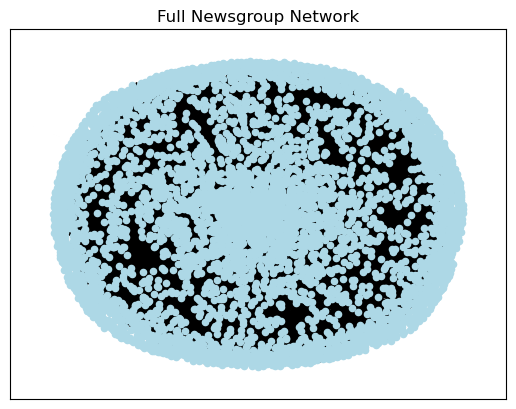

In [18]:
import matplotlib.pyplot as plt
isolated = [node for node in G.nodes if G.degree(node) <= 1]
G.remove_nodes_from(isolated)
# Find the largest weakly connected component
largest_component = max(nx.weakly_connected_components(G), key=len)
G_largest = G.subgraph(largest_component).copy()

pos = nx.spring_layout(G_largest)  # Layout algorithm to position nodes

# Draw the nodes and edges
nx.draw_networkx_nodes(G_largest, pos, node_size=20, node_color="lightblue")
nx.draw_networkx_edges(G_largest, pos, edgelist=G_largest.edges, arrowstyle='-|>', arrowsize=10)

# Draw the labels with smaller font size
#nx.draw_networkx_labels(G_largest, pos, font_size=8, font_color="black")
plt.title("Full Newsgroup Network")
plt.show()

Now, we can start analyzing the networks. Let's start by trying to look at the full network:

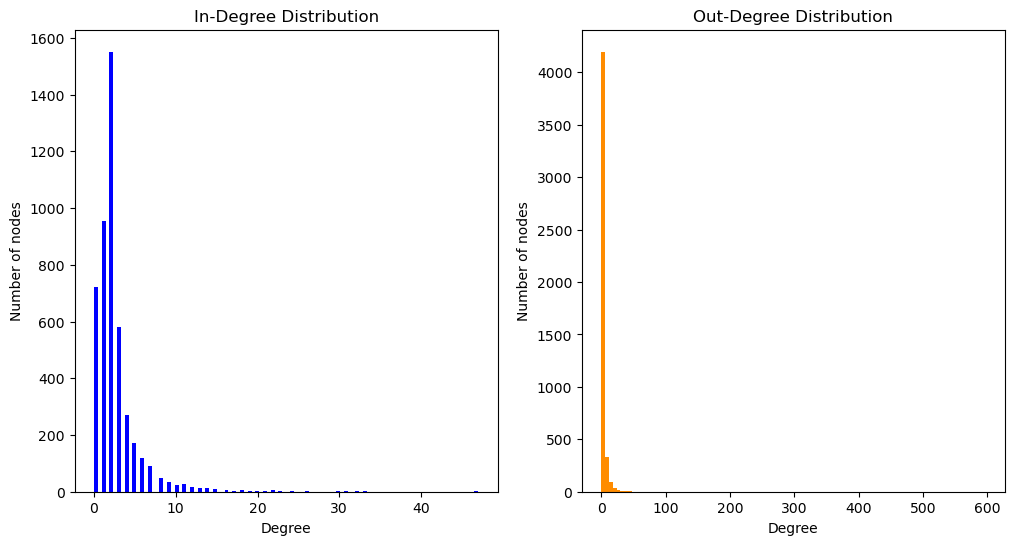

In [19]:
in_degrees = [degree for node,degree in G_largest.in_degree()]
out_degrees = [degree for node,degree in G_largest.out_degree()]

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(in_degrees, bins=100, color='blue')
plt.title('In-Degree Distribution')
plt.xlabel('Degree')
plt.ylabel('Number of nodes')

plt.subplot(1, 2, 2)
plt.hist(out_degrees, bins=100, color='darkorange')
plt.title('Out-Degree Distribution')
plt.xlabel('Degree')
plt.ylabel('Number of nodes')

plt.show()

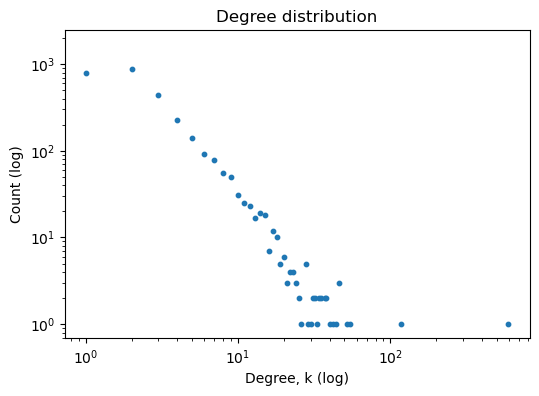

In [29]:
import numpy as np
degree_counts = np.bincount(out_degrees)
degree_range = np.arange(len(degree_counts))

plt.figure(figsize=(6, 4))
plt.scatter(degree_range,degree_counts, s=10)
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Degree, k (log)")
plt.ylabel("Count (log)")
plt.title("Degree distribution")
plt.show()

According the plot, it looks like the network does follow some kind of power law distribution. We take a look at the best fit, to see what kind:

In [30]:
import powerlaw
in_degrees = [G_largest.in_degree(node) for node in G_largest.nodes()]
out_degrees = [G_largest.out_degree(node) for node in G_largest.nodes()]
total_degrees = [G_largest.degree(node) for node in G_largest.nodes()]

fit_in = powerlaw.Fit(in_degrees)
alpha_in = fit_in.alpha
print(alpha_in)

fit_out = powerlaw.Fit(out_degrees)
alpha_out = fit_out.alpha
print(alpha_out)

fit_total = powerlaw.Fit(total_degrees)
alpha_total = fit_total.alpha
print(alpha_total)

Calculating best minimal value for power law fit
3.6508082093197403
Calculating best minimal value for power law fit
3.3384879829610816
Calculating best minimal value for power law fit
3.453302489592354%


Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


Here, all values of $\gamma > 3$, meaning they don't follow a scale-free regime, and are harder to distinguish from a random network of the same size. 

Now, we're interested in the most popular posters, as well as who has the most popular posts.

In [21]:
in_degree_dict = dict(G_largest.in_degree())
out_degree_dict = dict(G_largest.out_degree())

#Sort dictionary by second item of tuple
top_5_in_degree = sorted(in_degree_dict.items(), key=lambda x: x[1], reverse=True)[:5] 
top_5_out_degree = sorted(out_degree_dict.items(), key=lambda x: x[1], reverse=True)[:5]

print("Top 5 in-degrees: ", top_5_in_degree)

print("Top 5 out-degrees: ", top_5_out_degree)


Top 5 in-degrees:  [('strnlght@netcom.com', 47), ('sandvik@newton.apple.com', 33), ('henry@zoo.toronto.edu', 33), ('prb@access.digex.com', 32), ('cdt@sw.stratus.com', 31)]
Top 5 out-degrees:  [('weston@ucssun1.sdsu.edu', 597), ('nfotis@ntua.gr', 118), ('henry@zoo.toronto.edu', 54), ('cdt@sw.stratus.com', 52), ('livesey@solntze.wpd.sgi.com', 46)]


Interestingly, looking at the in-degrees, there isn't much difference between the top 5. However, in the out-degrees, there is a massive difference, especially between the number 1 and the rest. The number 1 has an almost 5 times higher out-degree than the number 2! Looking at the files, weston@ucssun1.sdsu.edu is an especially prolific poster in the comp.graphics newsgroup. This means he most likely references other senders especially often. 

Let's try looking at any possible community structures there are in each of the small networks:

100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:02<00:00, 846.39it/s]

BarnesHut Approximation  took  0.40  seconds
Repulsion forces  took  1.80  seconds
Gravitational forces  took  0.00  seconds
Attraction forces  took  0.03  seconds
AdjustSpeedAndApplyForces step  took  0.09  seconds


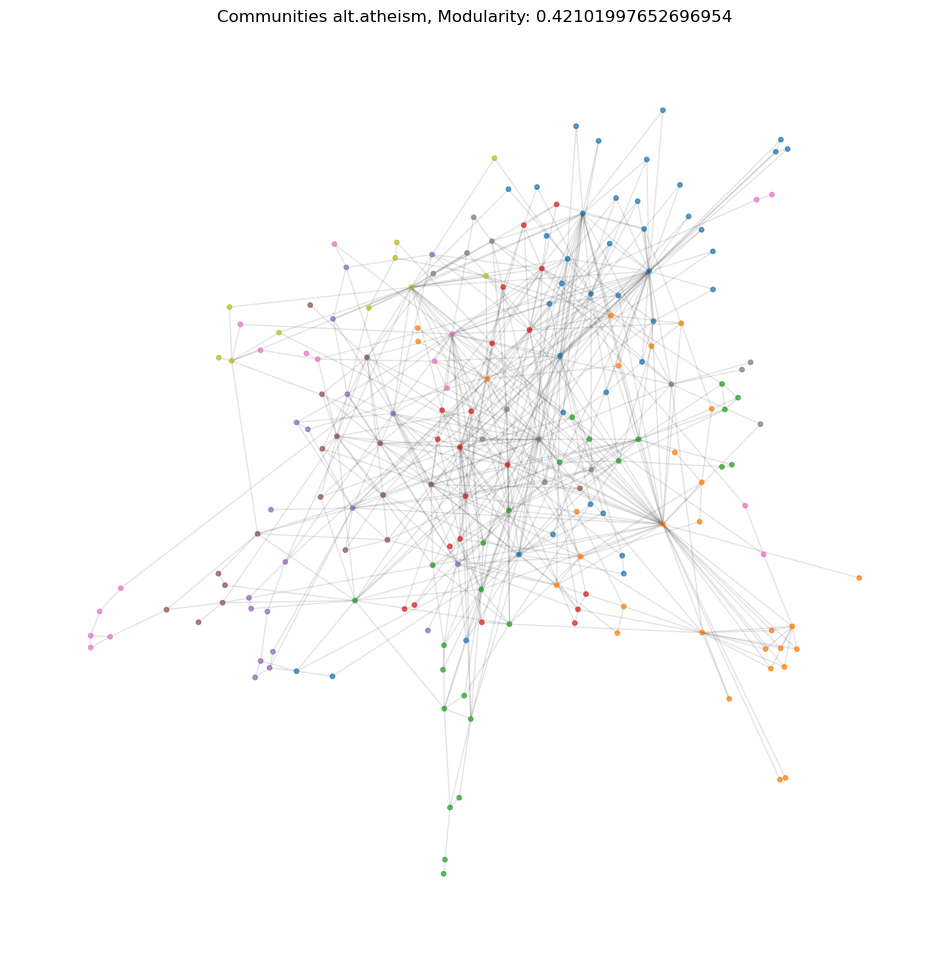

100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:11<00:00, 168.12it/s]


BarnesHut Approximation  took  4.11  seconds
Repulsion forces  took  6.86  seconds
Gravitational forces  took  0.11  seconds
Attraction forces  took  0.07  seconds
AdjustSpeedAndApplyForces step  took  0.45  seconds


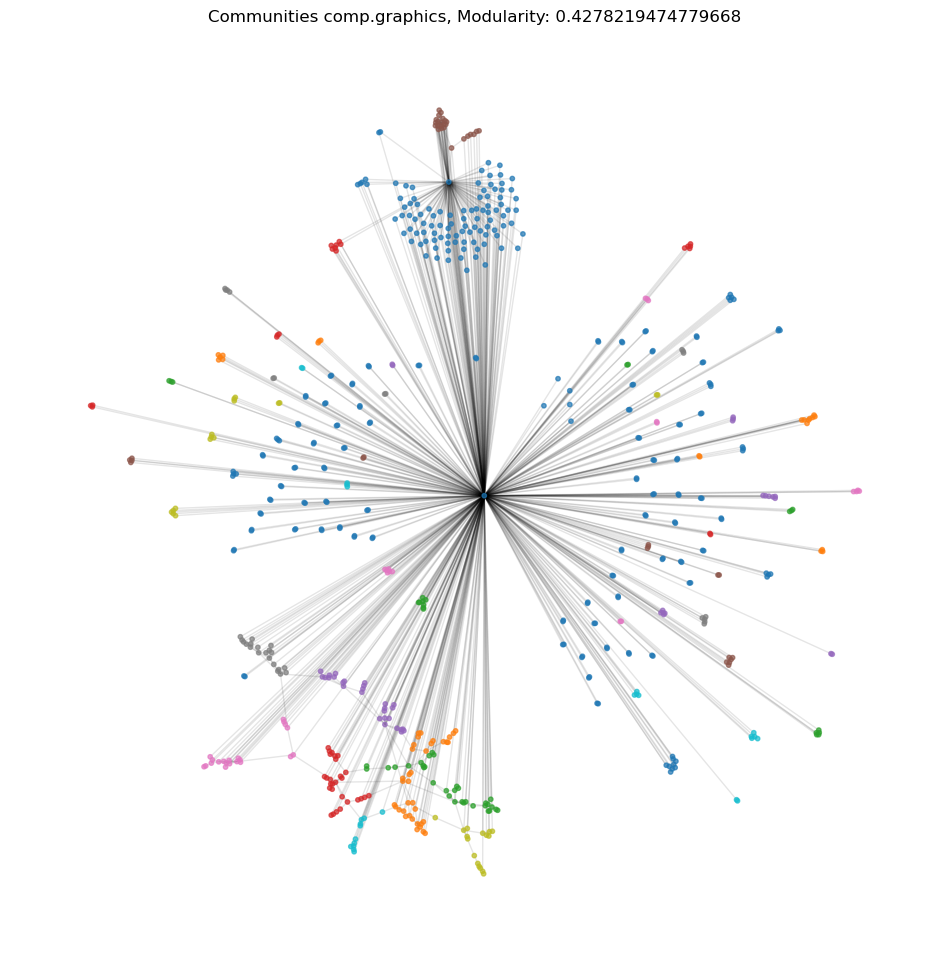

100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:03<00:00, 597.04it/s]

BarnesHut Approximation  took  0.79  seconds
Repulsion forces  took  2.25  seconds
Gravitational forces  took  0.04  seconds
Attraction forces  took  0.02  seconds
AdjustSpeedAndApplyForces step  took  0.14  seconds


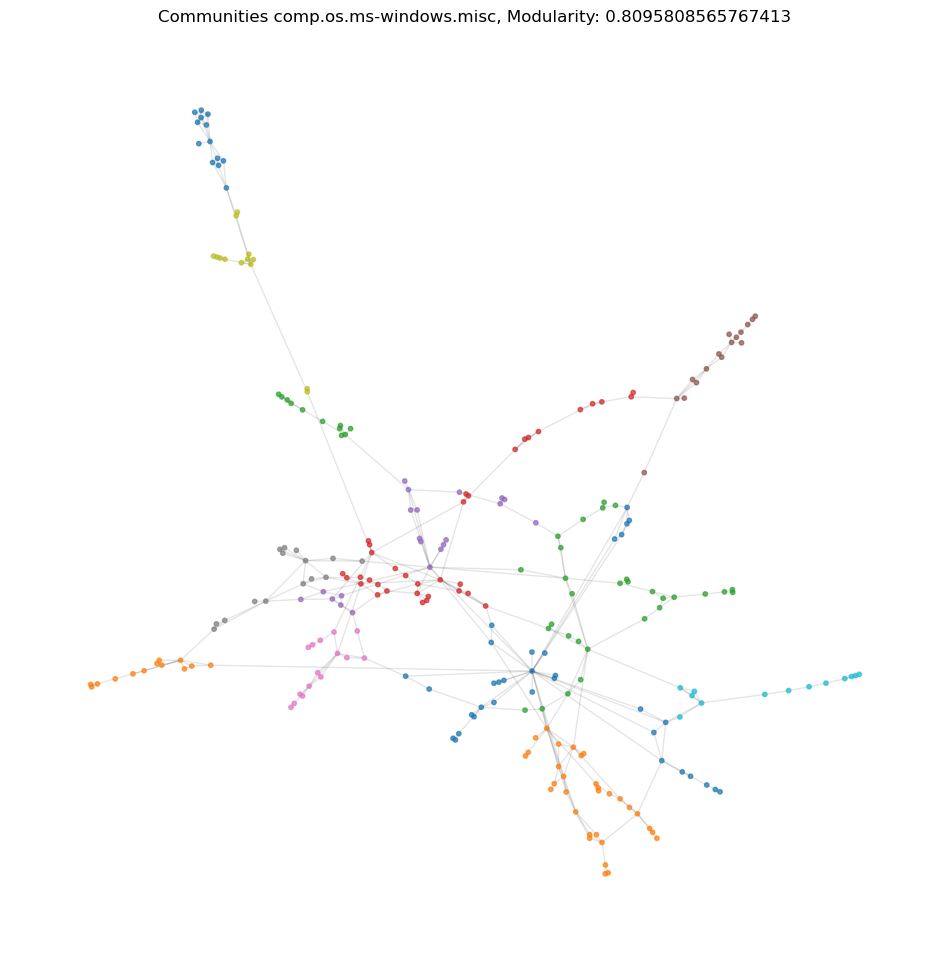

100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:02<00:00, 901.03it/s]


BarnesHut Approximation  took  0.45  seconds
Repulsion forces  took  1.57  seconds
Gravitational forces  took  0.02  seconds
Attraction forces  took  0.00  seconds
AdjustSpeedAndApplyForces step  took  0.12  seconds


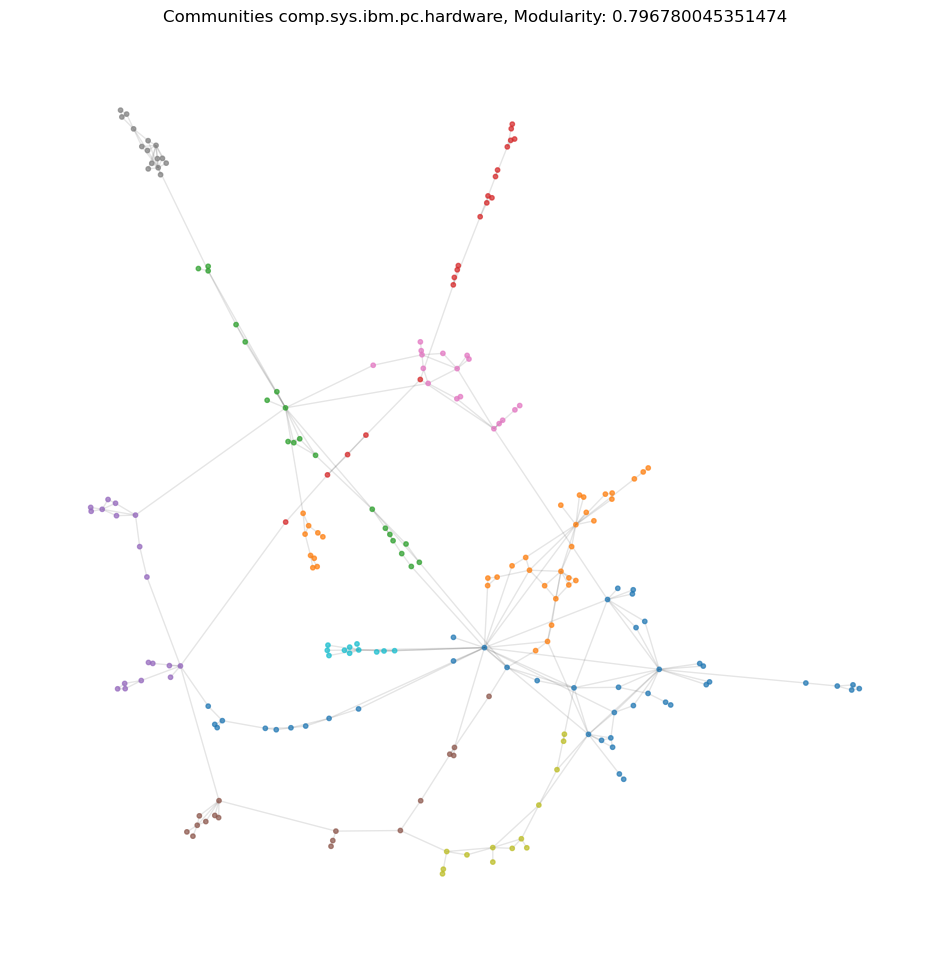

100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:02<00:00, 900.75it/s]


BarnesHut Approximation  took  0.66  seconds
Repulsion forces  took  1.39  seconds
Gravitational forces  took  0.02  seconds
Attraction forces  took  0.02  seconds
AdjustSpeedAndApplyForces step  took  0.10  seconds


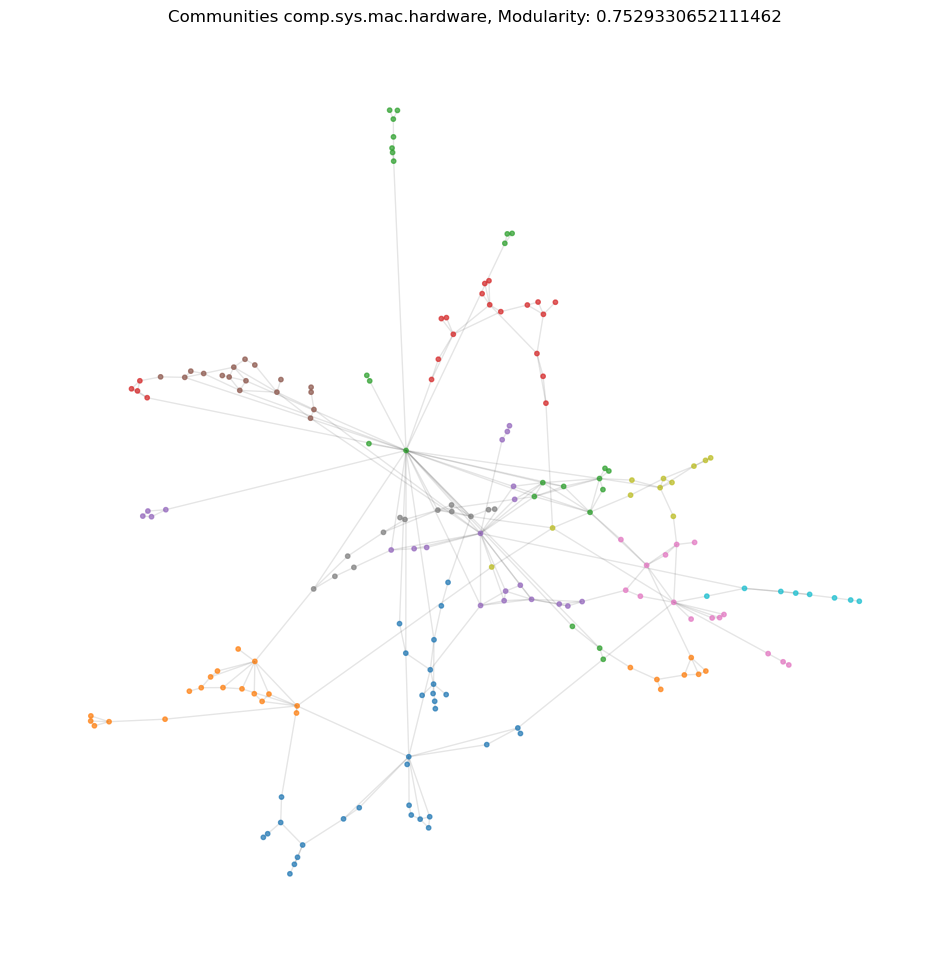

100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:02<00:00, 920.02it/s]

BarnesHut Approximation  took  0.38  seconds
Repulsion forces  took  1.57  seconds
Gravitational forces  took  0.03  seconds
Attraction forces  took  0.01  seconds
AdjustSpeedAndApplyForces step  took  0.09  seconds


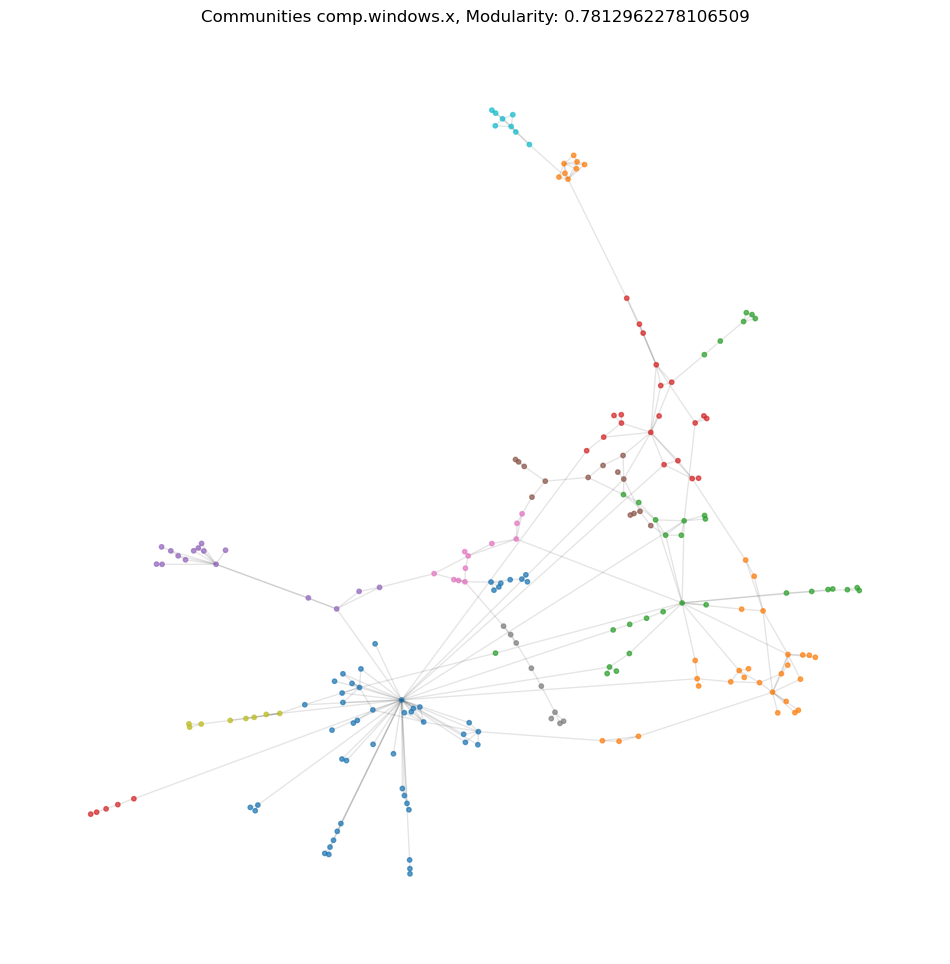

100%|███████████████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 41734.99it/s]


BarnesHut Approximation  took  0.02  seconds
Repulsion forces  took  0.00  seconds
Gravitational forces  took  0.00  seconds
Attraction forces  took  0.00  seconds
AdjustSpeedAndApplyForces step  took  0.00  seconds


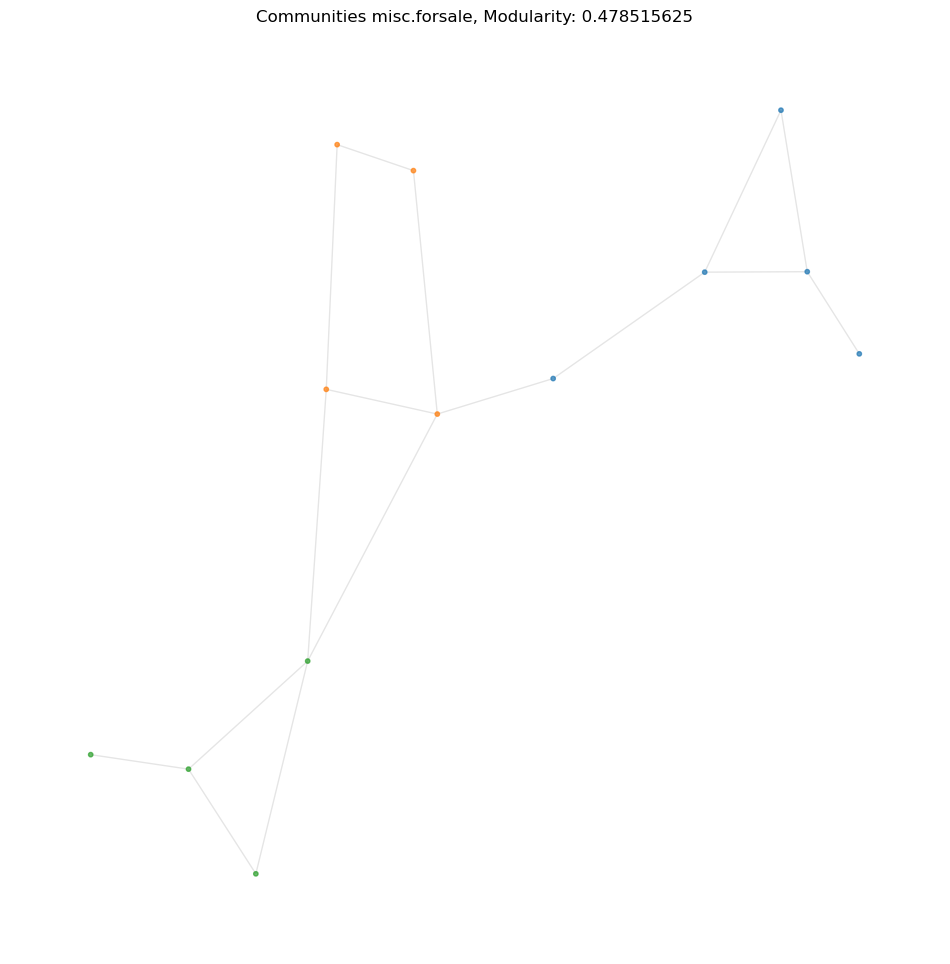

100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:05<00:00, 382.99it/s]


BarnesHut Approximation  took  1.33  seconds
Repulsion forces  took  3.50  seconds
Gravitational forces  took  0.08  seconds
Attraction forces  took  0.03  seconds
AdjustSpeedAndApplyForces step  took  0.17  seconds


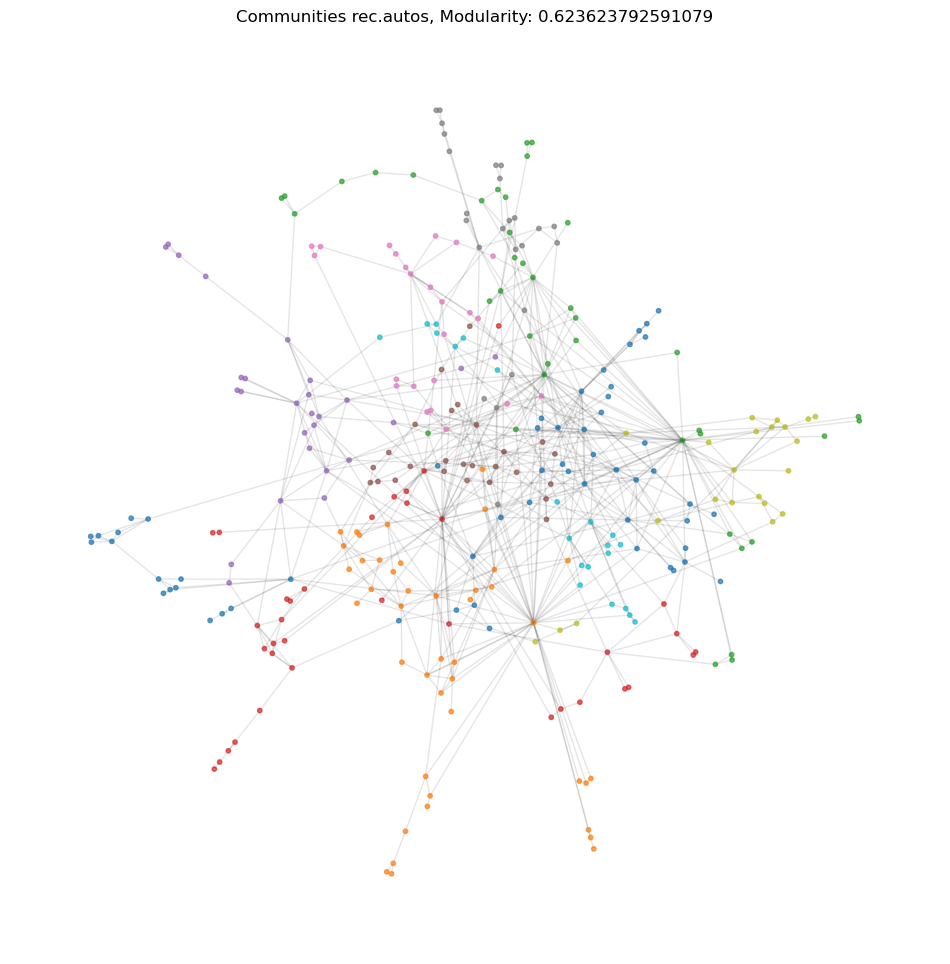

100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:05<00:00, 394.91it/s]


BarnesHut Approximation  took  0.84  seconds
Repulsion forces  took  3.86  seconds
Gravitational forces  took  0.03  seconds
Attraction forces  took  0.06  seconds
AdjustSpeedAndApplyForces step  took  0.20  seconds


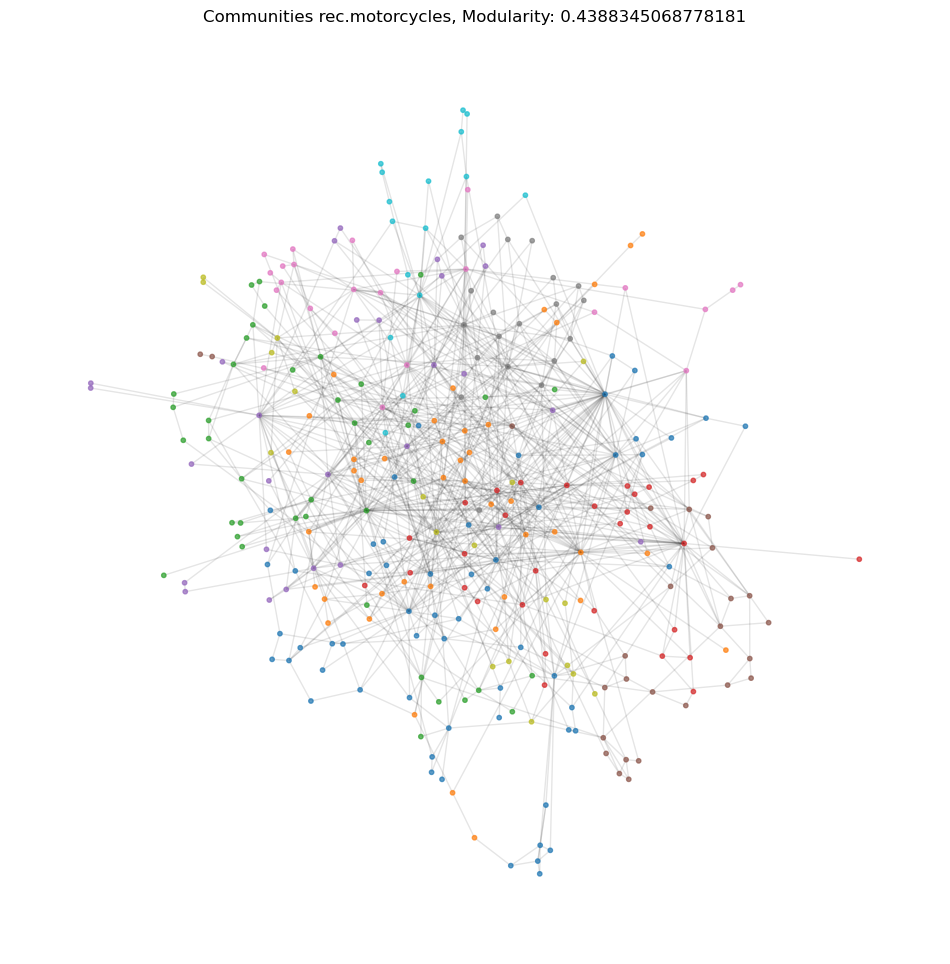

100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:04<00:00, 492.57it/s]


BarnesHut Approximation  took  0.52  seconds
Repulsion forces  took  3.20  seconds
Gravitational forces  took  0.03  seconds
Attraction forces  took  0.03  seconds
AdjustSpeedAndApplyForces step  took  0.17  seconds


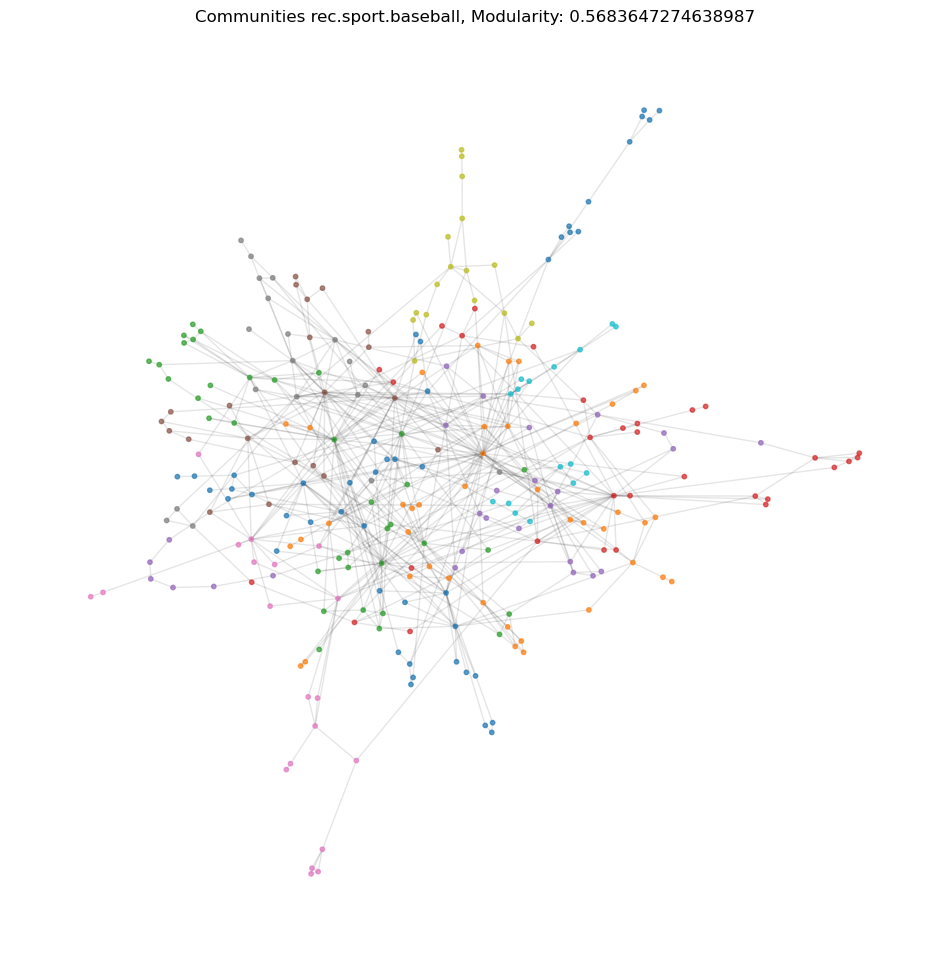

100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:03<00:00, 515.77it/s]


BarnesHut Approximation  took  0.89  seconds
Repulsion forces  took  2.60  seconds
Gravitational forces  took  0.05  seconds
Attraction forces  took  0.05  seconds
AdjustSpeedAndApplyForces step  took  0.20  seconds


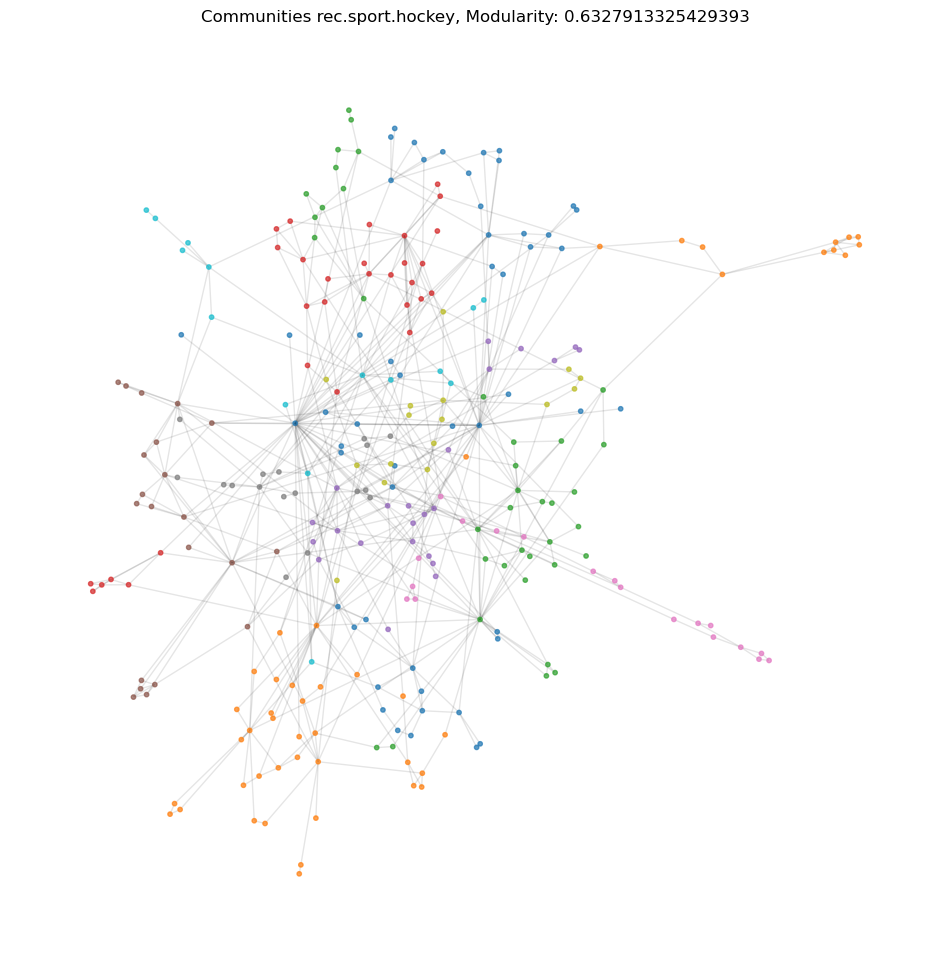

100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:03<00:00, 525.88it/s]


BarnesHut Approximation  took  0.51  seconds
Repulsion forces  took  2.99  seconds
Gravitational forces  took  0.02  seconds
Attraction forces  took  0.03  seconds
AdjustSpeedAndApplyForces step  took  0.17  seconds


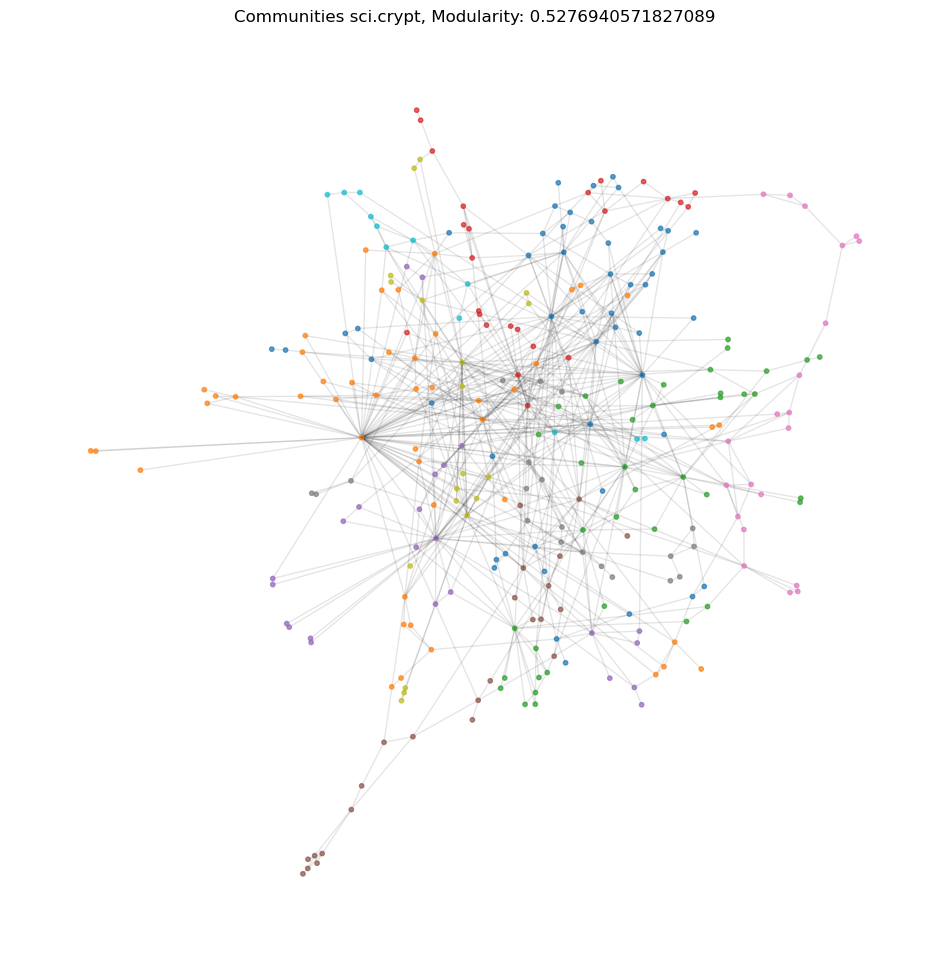

100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:03<00:00, 538.68it/s]


BarnesHut Approximation  took  0.91  seconds
Repulsion forces  took  2.51  seconds
Gravitational forces  took  0.03  seconds
Attraction forces  took  0.03  seconds
AdjustSpeedAndApplyForces step  took  0.11  seconds


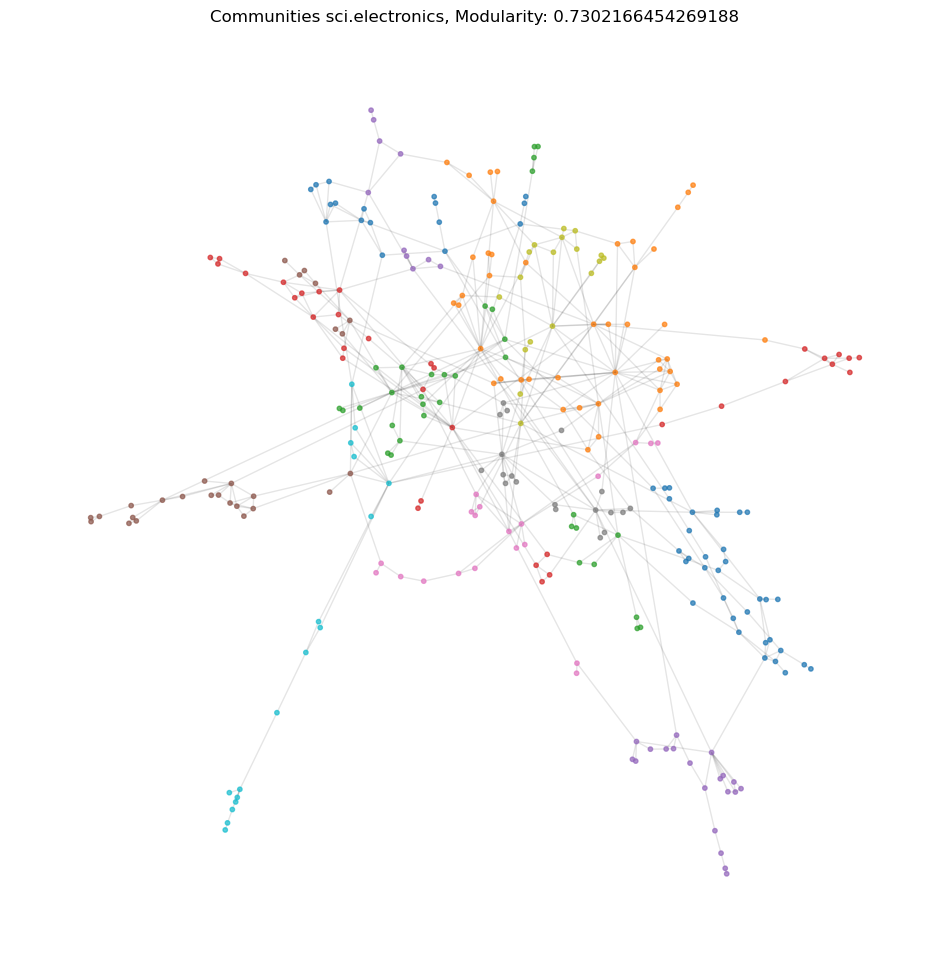

100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:03<00:00, 532.75it/s]


BarnesHut Approximation  took  0.91  seconds
Repulsion forces  took  2.60  seconds
Gravitational forces  took  0.01  seconds
Attraction forces  took  0.03  seconds
AdjustSpeedAndApplyForces step  took  0.13  seconds


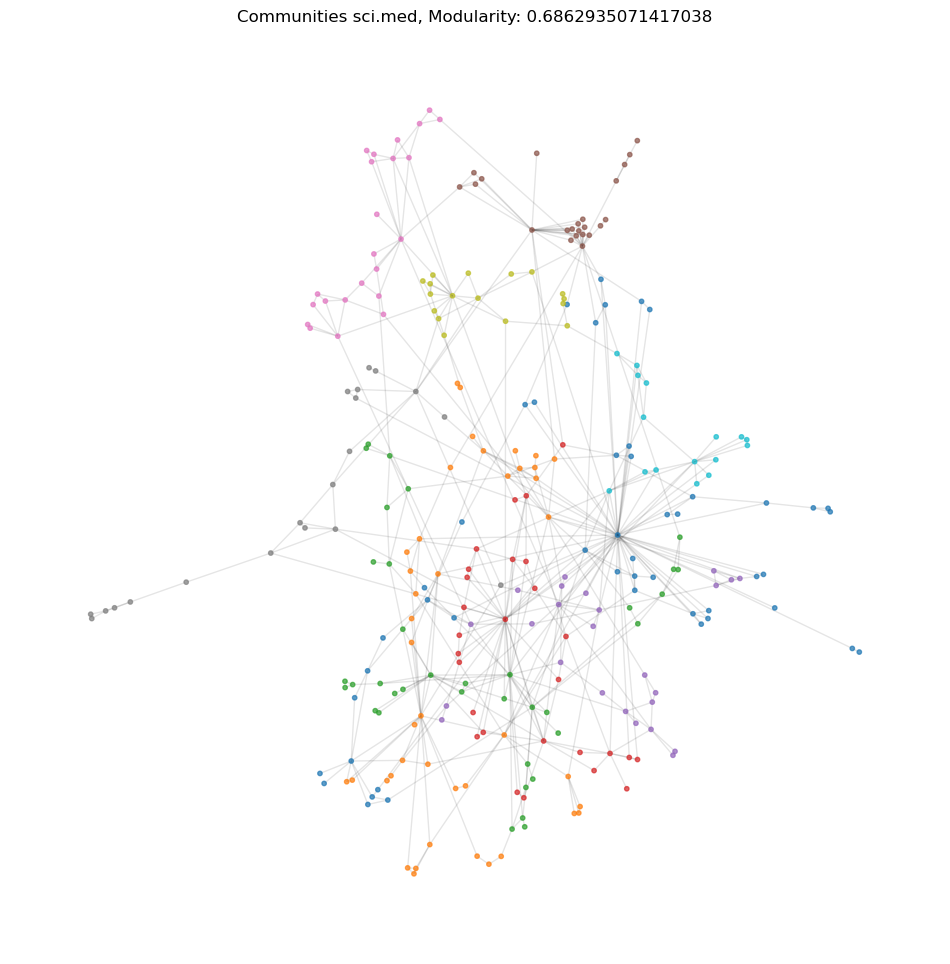

100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:04<00:00, 454.74it/s]


BarnesHut Approximation  took  0.55  seconds
Repulsion forces  took  3.49  seconds
Gravitational forces  took  0.02  seconds
Attraction forces  took  0.02  seconds
AdjustSpeedAndApplyForces step  took  0.19  seconds


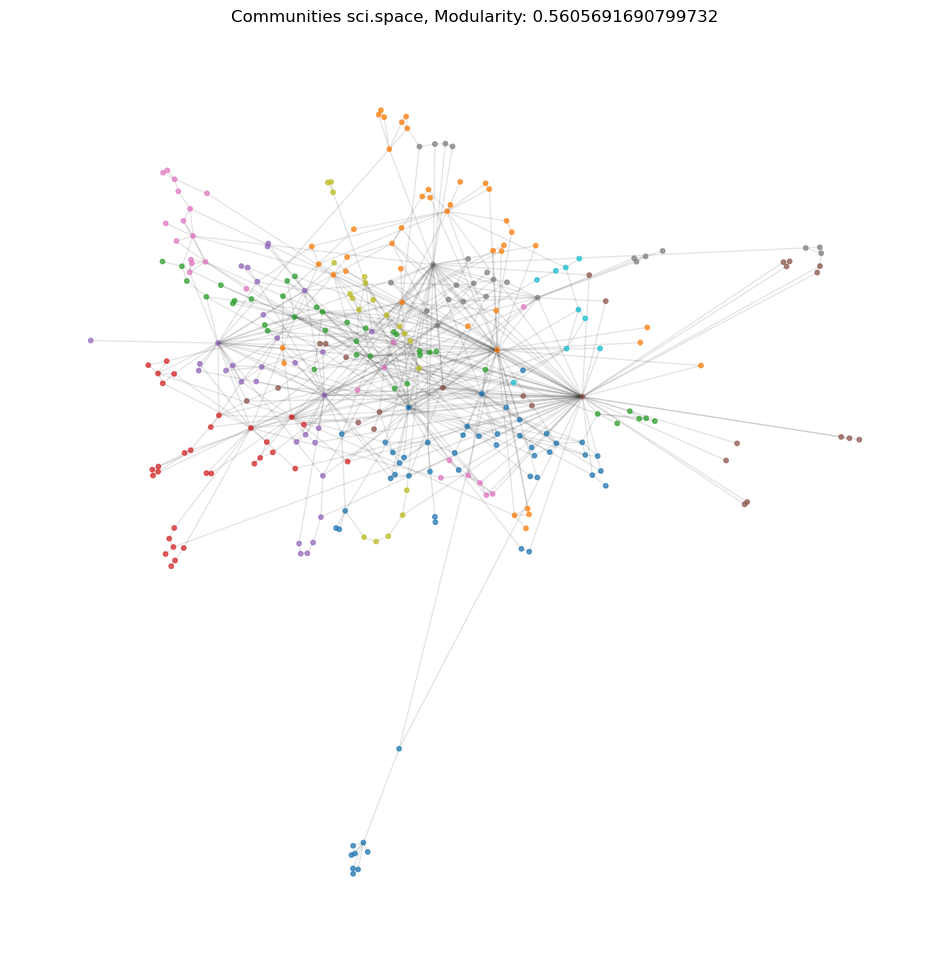

100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:03<00:00, 605.78it/s]

BarnesHut Approximation  took  0.82  seconds
Repulsion forces  took  2.15  seconds
Gravitational forces  took  0.04  seconds
Attraction forces  took  0.01  seconds
AdjustSpeedAndApplyForces step  took  0.20  seconds


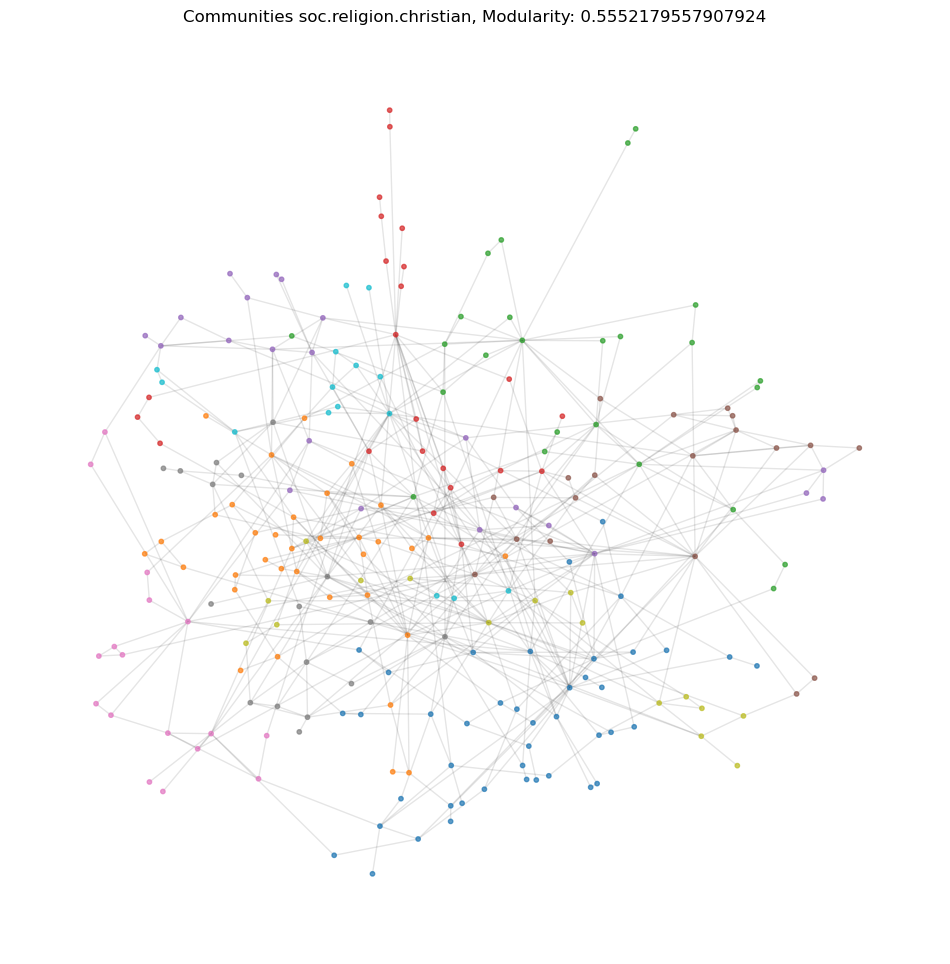

100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:03<00:00, 531.93it/s]


BarnesHut Approximation  took  0.47  seconds
Repulsion forces  took  2.97  seconds
Gravitational forces  took  0.03  seconds
Attraction forces  took  0.04  seconds
AdjustSpeedAndApplyForces step  took  0.16  seconds


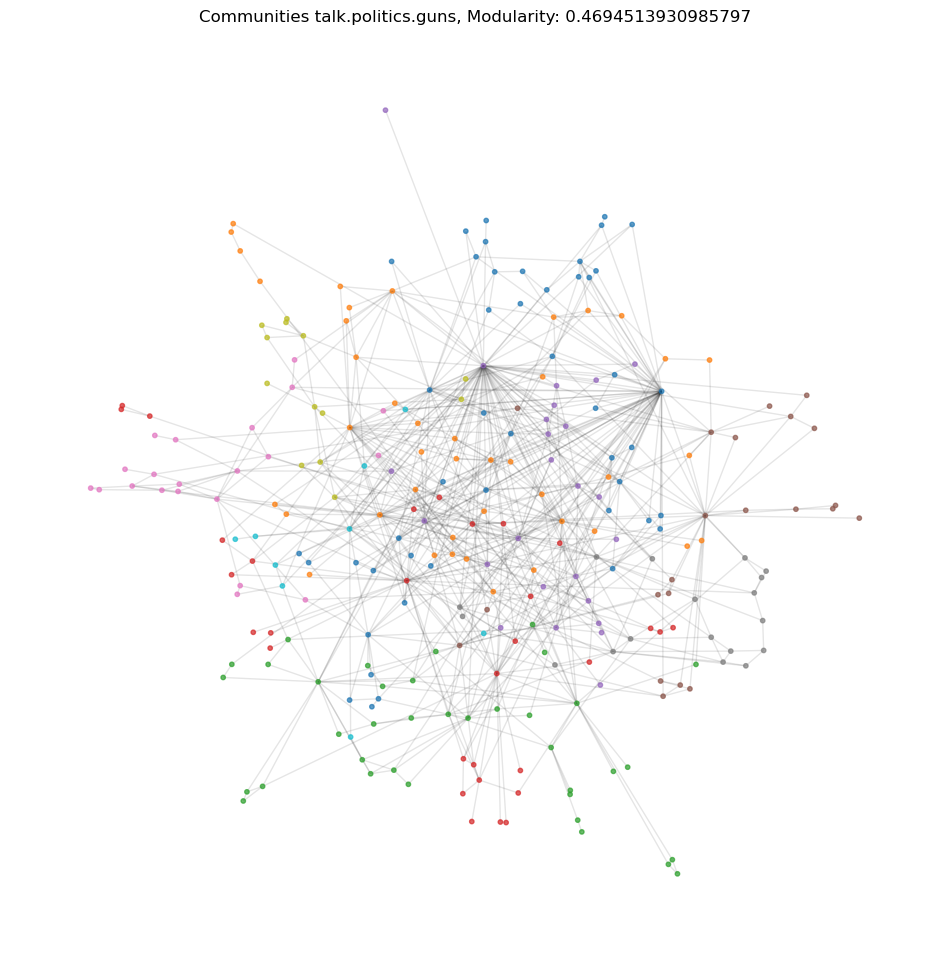

100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:02<00:00, 760.50it/s]


BarnesHut Approximation  took  0.66  seconds
Repulsion forces  took  1.74  seconds
Gravitational forces  took  0.03  seconds
Attraction forces  took  0.03  seconds
AdjustSpeedAndApplyForces step  took  0.11  seconds


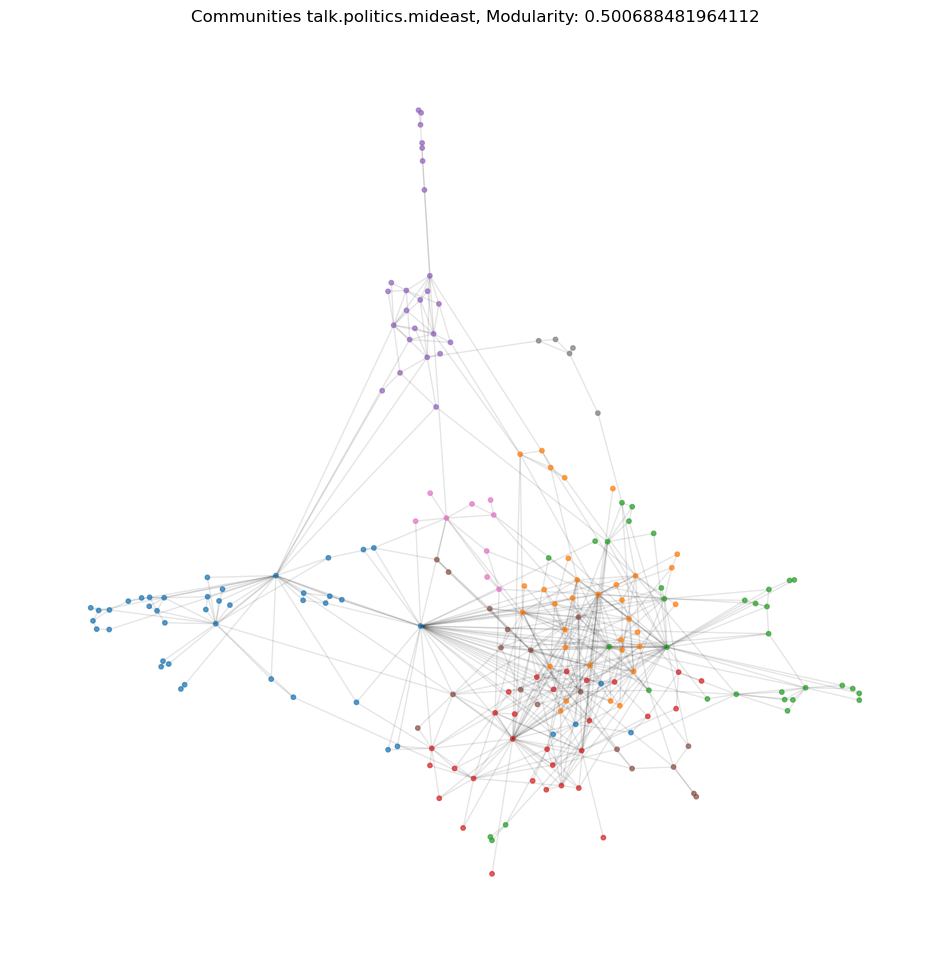

100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:03<00:00, 500.82it/s]


BarnesHut Approximation  took  0.80  seconds
Repulsion forces  took  2.88  seconds
Gravitational forces  took  0.04  seconds
Attraction forces  took  0.03  seconds
AdjustSpeedAndApplyForces step  took  0.16  seconds


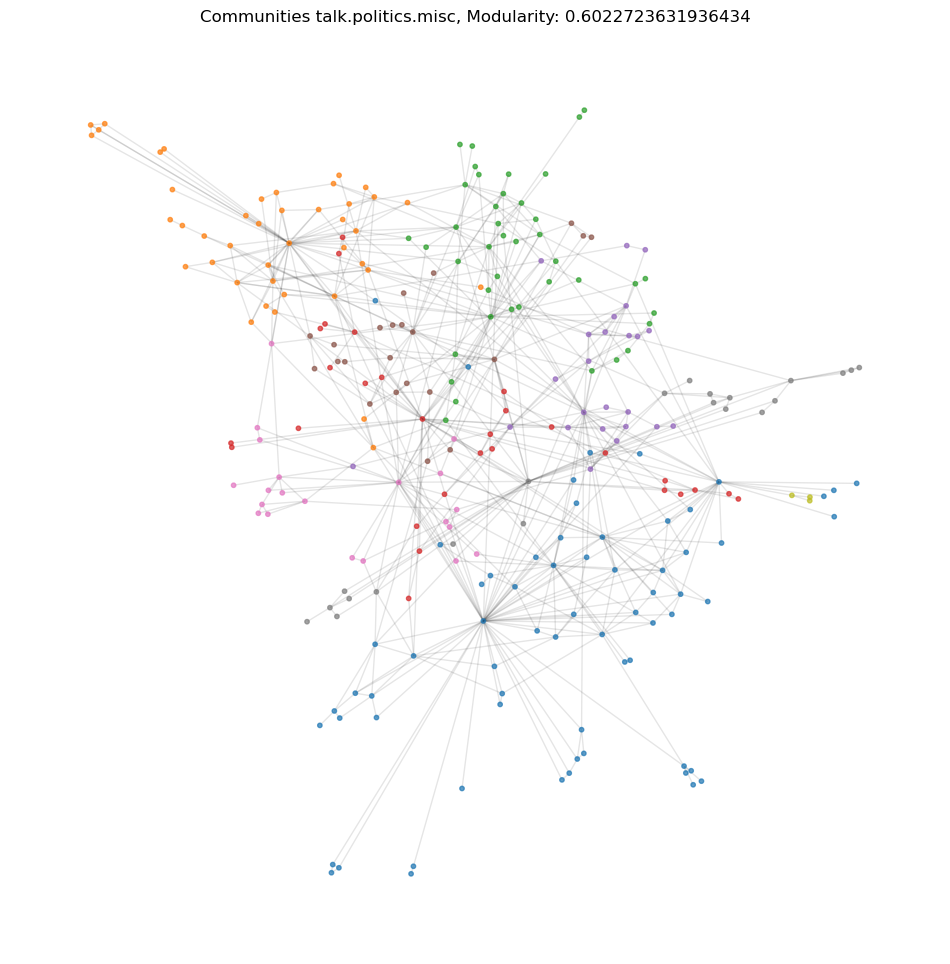

100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:02<00:00, 881.03it/s]


BarnesHut Approximation  took  0.44  seconds
Repulsion forces  took  1.62  seconds
Gravitational forces  took  0.01  seconds
Attraction forces  took  0.01  seconds
AdjustSpeedAndApplyForces step  took  0.13  seconds


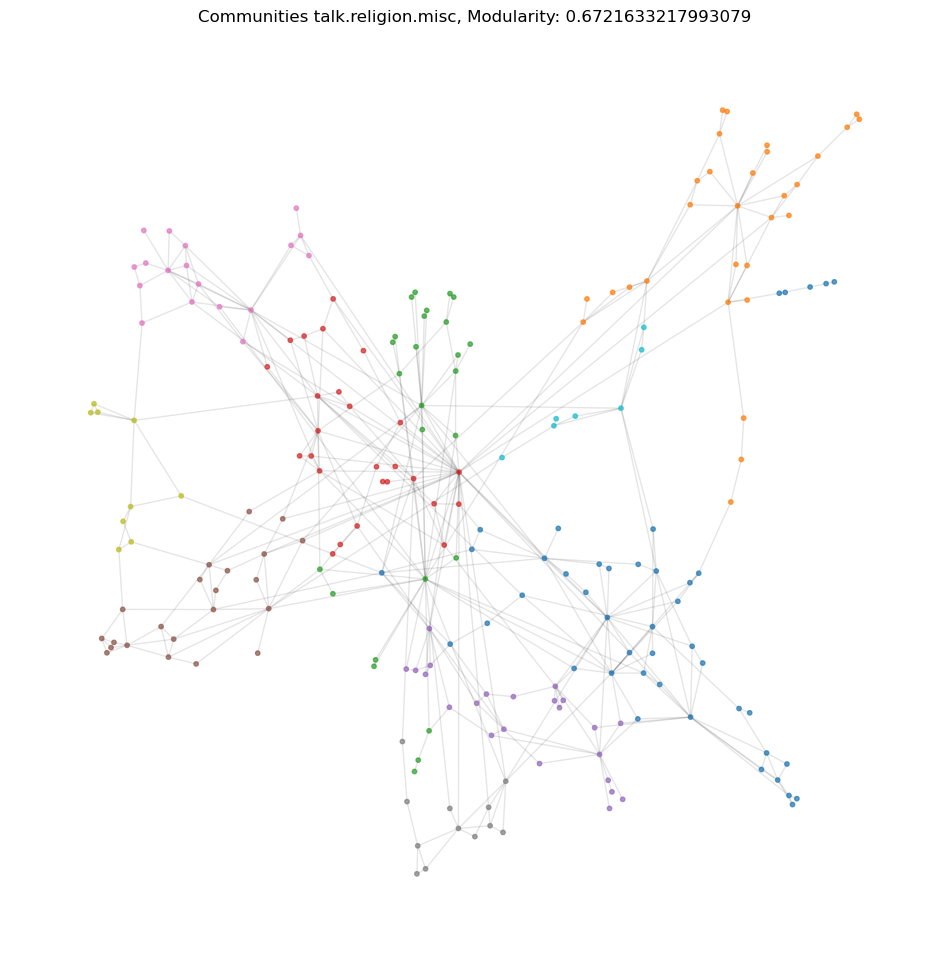

In [22]:
import community
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from fa2_modified import ForceAtlas2
import matplotlib.patches as mpatches

for title, G in graphs.items():
    G_undir = G.to_undirected()
    partition = community.best_partition(G_undir)
    forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=True,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1.0,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=2.0,
                        strongGravityMode=False,
                        gravity=1.0,
    
                        # Log
                        verbose=True)
    positions = forceatlas2.forceatlas2_networkx_layout(G_undir, pos=None, iterations=2000)
    
    community_sizes = {}
    for node, com in partition.items():
        if com not in community_sizes:
            community_sizes[com] = 0
        community_sizes[com] += 1
    
    top_communities = sorted(community_sizes, key=community_sizes.get, reverse=True)
    colors = list(mcolors.TABLEAU_COLORS.keys())
    community_color_map = {com: colors[i % len(colors)] for i, com in enumerate(top_communities)}
    neutral_color = "lightgray"

    
    legend_handles = []
    for com, color in community_color_map.items():
        legend_handles.append(mpatches.Patch(color=color, label=f'Community {com}'))

    
    node_colors = [
        community_color_map.get(partition[node], neutral_color) for node in G_undir.nodes()
    ]
    
    plt.figure(figsize=(12, 12))
    nx.draw_networkx_nodes(G_undir, positions, node_color=node_colors, node_size=10, alpha=0.7)
    nx.draw_networkx_edges(G_undir, positions, edge_color="black", alpha=0.1)
    mod = community.modularity(partition,G_undir)
    plt.title("Communities " + title + ", Modularity: " + str(mod))
    plt.axis("off")
    plt.show()

Looking at the modularity, most of the networks have pretty high modularity. This could be because communities arise when people answer each other often, or if a discussion constantly refers to a post made. This means most networks can be partitioned fairly easily into communities. We can try also looking at the entire network.

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [04:23<00:00,  7.59it/s]


BarnesHut Approximation  took  79.78  seconds
Repulsion forces  took  175.02  seconds
Gravitational forces  took  1.01  seconds
Attraction forces  took  1.01  seconds
AdjustSpeedAndApplyForces step  took  3.18  seconds


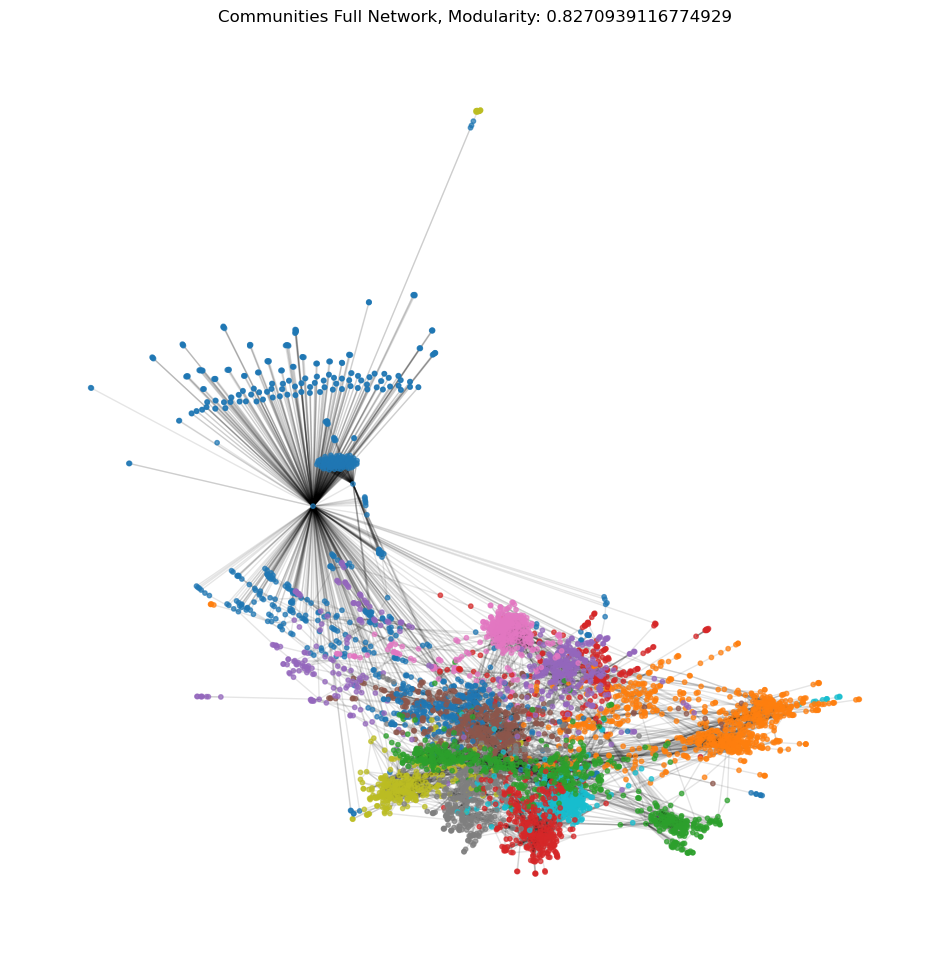

In [23]:
import community
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from fa2_modified import ForceAtlas2
import matplotlib.patches as mpatches

G_undir = G_largest.to_undirected()
partition = community.best_partition(G_undir)
forceatlas2 = ForceAtlas2(
                    # Behavior alternatives
                    outboundAttractionDistribution=True,  # Dissuade hubs
                    linLogMode=False,  # NOT IMPLEMENTED
                    adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                    edgeWeightInfluence=1.0,

                    # Performance
                    jitterTolerance=1.0,  # Tolerance
                    barnesHutOptimize=True,
                    barnesHutTheta=1.2,
                    multiThreaded=False,  # NOT IMPLEMENTED

                    # Tuning
                    scalingRatio=2.0,
                    strongGravityMode=False,
                    gravity=1.0,

                    # Log
                    verbose=True)
positions = forceatlas2.forceatlas2_networkx_layout(G_undir, pos=None, iterations=2000)

community_sizes = {}
for node, com in partition.items():
    if com not in community_sizes:
        community_sizes[com] = 0
    community_sizes[com] += 1

top_communities = sorted(community_sizes, key=community_sizes.get, reverse=True)
colors = list(mcolors.TABLEAU_COLORS.keys())
community_color_map = {com: colors[i % len(colors)] for i, com in enumerate(top_communities)}
neutral_color = "lightgray"

legend_handles = []
for com, color in community_color_map.items():
    legend_handles.append(mpatches.Patch(color=color, label=f'Community {com}'))
        
node_colors = [
    community_color_map.get(partition[node], neutral_color) for node in G_undir.nodes()
]

plt.figure(figsize=(12, 12))
nx.draw_networkx_nodes(G_undir, positions, node_color=node_colors, node_size=10, alpha=0.7)
nx.draw_networkx_edges(G_undir, positions, edge_color="black", alpha=0.1)
mod = community.modularity(partition,G_undir)
plt.title("Communities " + "Full Network" + ", Modularity: " + str(mod))
plt.axis("off")
plt.show()

Looking at the network, we can see the modularity is high. We're curious if the communities correspond to newsgroups only, or if there are more overarching communities. We can do that by creating a confusion matrix using both the communities found by the community library and the newsgroups on each node.

In [24]:
import numpy as np
import pandas as pd
from collections import Counter
import community
import networkx as nx
import matplotlib.pyplot as plt
G = create_full_network()
G_undir = G.to_undirected()
partition = community.best_partition(G_undir)
node_groups = nx.get_node_attributes(G_undir,"newsgroup")
all_groups = ([group for group in node_groups.values()])

# Find the top newsgroups and top communities (here we use 20 most common, as that is the amount of newsgroups)
group_counts = Counter(all_groups)
top_groups = [group for group, _ in group_counts.most_common(20)]

community_counts = Counter(partition.values())
top_communities = [community for community, _ in community_counts.most_common(20)]

#Map genre and community to indices
group_to_index = {group: i for i, group in enumerate(top_groups)}
community_to_index = {community: j for j, community in enumerate(top_communities)}

#Initialize the confusion matrix
D = np.zeros((20, 20), dtype=int)

#Fill the confusion matrix
for node, group in node_groups.items():
    community = partition.get(node)
    
    if community in community_to_index:
        j = community_to_index[community]
        # Check if the node's genre and community are in the top communities
        if group in group_to_index:
            i = group_to_index[group]
            D[i, j] += 1

# Convert the matrix to a DataFrame for easier viewing
print(top_communities)
confusion_df = pd.DataFrame(D, index=top_groups, columns=top_communities)

# Display the confusion matrix
print("Confusion Matrix (Group vs Community):")
print(confusion_df)

skipping first 0
[8, 3, 11, 4, 15, 22, 0, 2, 10, 7, 6, 20, 14, 18, 21, 17, 5, 1, 19, 13]
Confusion Matrix (Group vs Community):
                           8    3    11   4    15   22  0    2    10   7   \
comp.graphics             275    1    0    1    0    1   0    1    2    0   
sci.electronics             4    3   12    0   16    5   1    1    1  151   
sci.space                   6    5  194    0    3    1   1    7    1    2   
rec.motorcycles             1    0    1    1   14  207   1    0    0    2   
sci.med                     3    2    0    1    4    1   6    6    2    9   
rec.autos                   0    2    1    0  181   15   2    2    0    3   
comp.os.ms-windows.misc     3    3    3    0    2    0   4    3    2    3   
rec.sport.baseball          0    1    0  201    5    0   0    1    6    3   
talk.politics.misc          2   95    1   10    4    1   8    5    6    0   
sci.crypt                   0    9    1    0    1    1   1  192    0    4   
rec.sport.hockey         

There seems to be a lot of correlation between community and newsgroups. Some of the communities have a significant portion being from a certain newsgroup. Some have several related newsgroups, such community 12, which has a specific sports interest, with users posting in both rec.sport.baseball and rec.sport.hockey. Others are less significant, having no clear "winner" within newsgroups. 

Since some of the newsgroups are in several communities, we can see that some users do use many different newsgroups, not only one. To further analyze this we can update our networks to include the different newsgroups that each user posts in, as well as find the most used newsgroup for each user. But to do this, we must update our current data. We start by combining all the created JSONs into one big file:

In [25]:
import os
import json
newsgroups_jsons = os.listdir()
print(newsgroups_jsons)
combined = []
for file in newsgroups_jsons:
    if "json" in file:
        with open(file,'r', encoding='utf-8') as f:
            data = json.load(f)
            print(file)
            combined.extend(data)
        
with open('combined.json', 'w', encoding='utf-8') as f:
    json.dump(combined, f, indent=4)

['.ipynb_checkpoints', 'alt.atheism.json', 'combined.json', 'comp.graphics.json', 'comp.os.ms-windows.misc.json', 'comp.sys.ibm.pc.hardware.json', 'comp.sys.mac.hardware.json', 'comp.windows.x.json', 'degree_dist.png', 'in_degree_dist.png', 'misc.forsale.json', 'newsgroups', 'Newsgroups-Assignment.ipynb', 'Newsgroups.ipynb', 'out_degree_dist.png', 'rec.autos.csv', 'rec.autos.json', 'rec.motorcycles.json', 'rec.sport.baseball.json', 'rec.sport.hockey.json', 'sci.crypt.json', 'sci.electronics.json', 'sci.med.json', 'sci.space.json', 'soc.religion.christian.json', 'talk.politics.guns.json', 'talk.politics.mideast.json', 'talk.politics.misc.json', 'talk.religion.misc.json', 'updated_combined.json']
alt.atheism.json
combined.json
comp.graphics.json
comp.os.ms-windows.misc.json
comp.sys.ibm.pc.hardware.json
comp.sys.mac.hardware.json
comp.windows.x.json
misc.forsale.json
rec.autos.json
rec.motorcycles.json
rec.sport.baseball.json
rec.sport.hockey.json
sci.crypt.json
sci.electronics.json
sci.

Since we now have a combined JSON, with all posts from our dataset, we can look into the different newsgroups.

In [26]:
import json
from collections import defaultdict, Counter

with open('combined.json', 'r', encoding='utf-8') as f:
    combined_data = json.load(f)

senders_data = defaultdict(list)

# Populate senders_data with sender and their associated newsgroups
for item in combined_data:
    sender = item.get("sender")
    newsgroup = item.get("newsgroup")
    #Ensure both fields exist
    if sender and newsgroup: 
        senders_data[sender].append(newsgroup)

# Find unique newsgroups and most used newsgroup for each sender
senders_info = {}
for sender, newsgroups in senders_data.items():
    # Count occurrences of each newsgroup
    newsgroup_counts = Counter(newsgroups)  
    # Unique newsgroups
    used_newsgroups = list(newsgroup_counts.keys())  
    # Most used newsgroup
    most_used_newsgroup = newsgroup_counts.most_common(1)[0][0]  

    senders_info[sender] = {
        "used_newsgroups": used_newsgroups,
        "used_newsgroups_counts": newsgroup_counts,
        "most_used_newsgroup": most_used_newsgroup,
    }

newsgroups = os.listdir()
#Add attributes to each item in the combined data
for file in newsgroups:
    if ".json" in file:
        with open(file , 'r', encoding='utf-8') as f:
            newsgroup = json.load(f)
        for item in newsgroup:
            sender = item.get("sender")
            if sender in senders_info:
                item["used_newsgroups"] = senders_info[sender]["used_newsgroups"]
                item["used_newsgroups_counts"] = senders_info[sender]["used_newsgroups_counts"]
                item["most_used_newsgroup"] = senders_info[sender]["most_used_newsgroup"]
        
        # Step 5: Save updated data
        with open(file, 'w', encoding='utf-8') as f:
            json.dump(newsgroup, f, indent=4)
    
        print(f"Updated data saved to '{file}'.")

Updated data saved to 'alt.atheism.json'.
Updated data saved to 'combined.json'.
Updated data saved to 'comp.graphics.json'.
Updated data saved to 'comp.os.ms-windows.misc.json'.
Updated data saved to 'comp.sys.ibm.pc.hardware.json'.
Updated data saved to 'comp.sys.mac.hardware.json'.
Updated data saved to 'comp.windows.x.json'.
Updated data saved to 'misc.forsale.json'.
Updated data saved to 'rec.autos.json'.
Updated data saved to 'rec.motorcycles.json'.
Updated data saved to 'rec.sport.baseball.json'.
Updated data saved to 'rec.sport.hockey.json'.
Updated data saved to 'sci.crypt.json'.
Updated data saved to 'sci.electronics.json'.
Updated data saved to 'sci.med.json'.
Updated data saved to 'sci.space.json'.
Updated data saved to 'soc.religion.christian.json'.
Updated data saved to 'talk.politics.guns.json'.
Updated data saved to 'talk.politics.mideast.json'.
Updated data saved to 'talk.politics.misc.json'.
Updated data saved to 'talk.religion.misc.json'.
Updated data saved to 'updat

Now that the JSON files have been updated with the new information, we can look at how this affects the network. First, the networks have to be updated to include the new data. Here, we needed an added check: if a node has been added as an edge, it won't have the attributes connected, causing errors later. So we have to make sure to add the attributes to the already existing node. We also add every post's content to each sender, meaning each node will basically have a list of posts as an attribute, for later analysis. 

In [27]:
import json
import re
import os
import networkx as nx
def create_newsgroup_networks():
    newsgroups = os.listdir("./newsgroups")
    newsgroups.remove("list.csv")
    graphs = {}
    message_id_pattern = re.compile(r'<[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}>')  # Matches Message-IDs
    email_pattern = re.compile(r'\b[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}\b')
    for title in newsgroups:
        G = nx.DiGraph()
        with open(title.replace(".txt","")+".json", 'r', encoding="utf-8") as file:
            data = json.load(file)
        for i,post in enumerate(data):
            title_san = title.replace(".txt","")
            if "alt.atheism" in title and i == 0:
                #skip first post in alt.atheism (doesn't have standard post metadata)
                print("skipping first", i)
                continue
            sender_email = email_pattern.search(post["sender"].lower())
            if sender_email == None:
                #If no email found, skip
                continue
            sender_email = sender_email.group(0)
            if not G.has_node(sender_email):
                G.add_node(sender_email,
                           newsgroup = title_san, 
                           used_newsgroups = post["used_newsgroups"],
                           newsgroup_counts = post["used_newsgroups_counts"], 
                           most_used_newsgroup = post["most_used_newsgroup"],
                           posts = [post["content"]])
            else:
                #Check if sender was added through edge, and then doesn't have the correct attributes
                if 'posts' not in G.nodes[sender_email]:
                    G.add_node(sender_email,
                           newsgroup = title_san, 
                           used_newsgroups = post["used_newsgroups"],
                           newsgroup_counts = post["used_newsgroups_counts"], 
                           most_used_newsgroup = post["most_used_newsgroup"],
                           posts = [post["content"]])
                if post["content"] not in G.nodes[sender_email]['posts']:
                    G.nodes[sender_email]['posts'].append(post["content"])  # Append to existing list
            content = post["content"].lower()
            emails = email_pattern.findall(content)
            message_ids = message_id_pattern.findall(content)
            message_ids_san = [mes_id.strip('<>') for mes_id in message_ids]
            
            emails_filtered = [email for email in emails if email not in message_ids_san]
            for email in emails_filtered:
                if email != sender_email:
                    G.add_edge(sender_email,email)
            
        graphs[title.replace(".txt","")] = G

    return graphs;
graphs = create_newsgroup_networks()

skipping first 0


In [28]:
def create_full_network():
    newsgroups = os.listdir("./newsgroups")
    newsgroups.remove("list.csv")
    message_id_pattern = re.compile(r'<[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}>')  # Matches Message-IDs
    email_pattern = re.compile(r'\b[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}\b')

    G = nx.DiGraph()
    for title in newsgroups:
        with open(title.replace(".txt","")+".json", 'r', encoding="utf-8") as file:
            data = json.load(file)
        for i,post in enumerate(data):
            if "alt.atheism" in title and i == 0:
                #skip first post in alt.atheism (doesn't have standard post metadata)
                print("skipping first", i)
                continue
    
            title_san = title.replace(".txt","")
            sender_email = email_pattern.search(post["sender"].lower())
            if sender_email == None:
                #If no email found, skip
                continue
            sender_email = sender_email.group(0)
            if not G.has_node(sender_email):
                G.add_node(sender_email,
                           newsgroup = title_san, 
                           used_newsgroups = post["used_newsgroups"],
                           newsgroup_counts = post["used_newsgroups_counts"], 
                           most_used_newsgroup = post["most_used_newsgroup"],
                           posts = [post["content"]])
            else:
                #Check if sender was added through edge, and then doesn't have the correct attributes
                if 'posts' not in G.nodes[sender_email]:
                    G.add_node(sender_email,
                           newsgroup = title_san, 
                           used_newsgroups = post["used_newsgroups"],
                           newsgroup_counts = post["used_newsgroups_counts"], 
                           most_used_newsgroup = post["most_used_newsgroup"],
                           posts = [post["content"]])
                if post["content"] not in G.nodes[sender_email]['posts']:
                    G.nodes[sender_email]['posts'].append(post["content"])  # Append to existing list
            content = post["content"].lower()
            emails = email_pattern.findall(content)
            message_ids = message_id_pattern.findall(content)
            message_ids_san = [mes_id.strip('<>') for mes_id in message_ids]
            
            emails_filtered = [email for email in emails if email not in message_ids_san]
            for email in emails_filtered:
                if email != sender_email:
                    G.add_edge(sender_email,email)
            
    return G
G = create_full_network()

skipping first 0
